In [1]:
print('Kernel Initialized')

Kernel Initialized


In [2]:

# Imports
import sys
sys.path.append("..")
import pandas as pd
import numpy as np
from utils import Utils
import plot_utils as plotting
import toml
from sklearn import preprocessing, model_selection, metrics
import seaborn as sns
import random


import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
plt.style.use("seaborn-v0_8-whitegrid")
from scipy.special import logit, expit
import os

#import verstack
import Verstack_cluster_safe.LGBMTuner as verstack
import optuna
random.seed(42)
from iminuit import Minuit
from scipy import stats
mpl.rcParams.update({
    'text.usetex': False,
    'font.family': 'stixgeneral',
    'mathtext.fontset': 'stix',
    })

import scipy.integrate as integrate

In [3]:
config = toml.load('config.toml')
Storage = Utils.HDF5_IO(config['PATHS']['Storage'])

Features_to_be_read = []
for k, v in config['features'].items():
    Features_to_be_read.extend(v)
features = config['features']['ML_features']

# Apply Global, Local and Mass Hypothesis selection

In [4]:
def get_B_mass_true(df):
    print('Adding True Mass Column..')
    df["B_mass_true"] = ( (df["info_is_true_nonres_Bd"]) | (df["info_is_true_res_Bd"]) ) * df["B_mass"] + ( (df["info_is_true_nonres_BdBar"]) | (df["info_is_true_res_BdBar"]) ) * df["Bbar_mass"]
    return df

def predict_double(Storage,X_target=None):
    print('Adding Predictions..')
    X = X_target.copy()

    # ------- BDT1 ----------
    root_tag = 'BDT1'
    model = Storage.load_lgbm(key=f"{root_tag}/model")
    feat_idx = model.feature_name()
    X=X[feat_idx]

    X_scaled = Utils.pd_scale(Storage,X, root_tag= root_tag)
    BDT_scores = model.predict(X_scaled.reindex(columns=feat_idx))

    X_target[f"P_{root_tag}_Bkg"], X_target[f"P_{root_tag}_Bd"],X_target[f"P_{root_tag}_BdBar"],X_target[f"P_{root_tag}_sum"], X_target[f"P_{root_tag}_max"] = BDT_scores[:,0], BDT_scores[:,1], BDT_scores[:,2], BDT_scores[:,1:].sum(axis=1), BDT_scores[:,1:].max(axis=1)

    # ------- BDT2 ----------
    root_tag = 'BDT2'
    model = Storage.load_lgbm(key=f"{root_tag}/model")
    feat_idx = model.feature_name()
    X=X[feat_idx]

    X_scaled = Utils.pd_scale(Storage,X, root_tag= root_tag)
    BDT_scores = model.predict(X_scaled.reindex(columns=feat_idx))

    X_target[f"P_{root_tag}_Bkg"], X_target[f"P_{root_tag}_Bd"],X_target[f"P_{root_tag}_BdBar"],X_target[f"P_{root_tag}_sum"], X_target[f"P_{root_tag}_max"] = BDT_scores[:,0], BDT_scores[:,1], BDT_scores[:,2], BDT_scores[:,1:].sum(axis=1), BDT_scores[:,1:].max(axis=1)

    X_target['P_BDT_max'] = np.max([X_target.P_BDT1_sum, X_target.P_BDT2_sum],axis=0)

    return X_target

def load_multiple_feather_files(file_list:list, selection:str, N_events:int, columns_to_read:list):
    print('Starts loading files..')
    files = []
    List_uniques_list = []
    for file_path in file_list:
        files.append(pd.read_feather(path=file_path, columns=columns_to_read, use_threads=True, storage_options=None))
    print('Done loading..')

    for i in range(len(files)):
        files[i] = files[i].query(selection)
        List_uniques = list(files[i]['info_event_number'].unique()[:N_events])
        List_uniques_list.append(List_uniques)
        files[i] = files[i][(files[i]['info_event_number'].isin(List_uniques))]

    print(f"Number of uniques: {[len(i) for i in List_uniques_list]}, total = {sum([len(i) for i in List_uniques_list])}")
    print(f"Length of files: {[len(i) for i in files]}, total = {sum([len(i) for i in files])}")

    df_files = pd.concat(files)
    df_files_w_true_mass = get_B_mass_true(df_files)
    df_files_w_true_mass_w_predictions = predict_double(Storage,df_files_w_true_mass)
    print('Done..')
    print()

    return df_files_w_true_mass_w_predictions


In [5]:
main = Utils.selection_cuts()['main']
select_ChargeSS = '(BeeKst_meson0_charge * BeeKst_meson1_charge > 0)'
select_ChargeOS = '(BeeKst_meson0_charge * BeeKst_meson1_charge < 0)'
select_q2_high = '( (BeeKst_diElectron_mass*BeeKst_diElectron_mass > 6e6) & (BeeKst_diElectron_mass*BeeKst_diElectron_mass <= 11e6) )'
select_b_mass_3000_6500 = "( ((BeeKst_B_mass) >= 3000) & ((BeeKst_B_mass) <= 6500))"
select_mass_4000_5700_outside = "( ((BeeKst_B_mass) >= 5700) | ((BeeKst_B_mass) <= 4000) )"
select_mass_4000_5700 = "( ((BeeKst_B_mass) < 5700) & ((BeeKst_B_mass) > 4000) )"
select_CR = "((BeeKst_chi2 > 20) & (BeeKst_chi2 <= 30))"
select_chi20 = "((BeeKst_chi2 < 20))"


In [6]:
def Data_loader():

    print('Loading MC background..')
    BKG_MC=pd.read_feather(path=config['train_files']['Bkg_MC'], columns=Features_to_be_read, use_threads=True, storage_options=None)
    BKG_MC = BKG_MC.query(Utils.selection_cuts()['main'])
    BKG_MC = BKG_MC.query(f"{select_q2_high} & {select_b_mass_3000_6500}")
    BKG_MC.info_sample = 'BKG_MC'
    label = (BKG_MC.info_sample == 0)*0
    for i in config['labels_scheme']:
        label += (BKG_MC.info_sample == str(i))*config['labels_scheme'][str(i)]
    BKG_MC['label'] = label

    return BKG_MC

BKG_MC = Data_loader()

Loading MC background..


In [7]:

Features_to_be_read = []
for k, v in config['features'].items():
    Features_to_be_read.extend(v)

files_dictionary = {
    'MC_signal': sorted([config['PATHS']['feather'] + x for x in os.listdir(config['PATHS']['feather']) if 'MC_signal_all_ntuple' in x ]),
    'Data': sorted([config['PATHS']['feather'] + x for x in os.listdir(config['PATHS']['feather']) if 'Data_All_K_ntuple-data18_13TeV_periodK_part' in x ])
    }

In [9]:
MC_USR_highq2 = load_multiple_feather_files(
    file_list = files_dictionary['MC_signal'], 
    selection = f"{main} & {select_ChargeOS} & {select_q2_high} & {select_b_mass_3000_6500} & {select_chi20}", 
    N_events = -1, 
    columns_to_read = Features_to_be_read)

Starts loading files..


KeyboardInterrupt: 

In [ ]:
DATA_SS_bkg = load_multiple_feather_files(
    file_list = files_dictionary['Data'], 
    selection = f"{main} & {select_ChargeSS} & {select_q2_high} & {select_b_mass_3000_6500}",
    N_events = -1, 
    columns_to_read = Features_to_be_read)

Starts loading files..
Done loading..
Number of uniques: [31429, 29467, 25991, 25695, 23817, 23508, 22056, 16833, 13254, 15902, 19902], total = 247854
Length of files: [329146, 304986, 272799, 270806, 248710, 248661, 230714, 181488, 140326, 175468, 221302], total = 2624406
Adding True Mass Column..
Adding Predictions..
Done..



In [ ]:

DATA_OS_bkg = load_multiple_feather_files(
    file_list = files_dictionary['Data'], 
    selection = f"{main} & {select_ChargeOS} & {select_q2_high} & {select_b_mass_3000_6500} & {select_mass_4000_5700_outside}",
    N_events = -1, 
    columns_to_read = Features_to_be_read)


Starts loading files..
Done loading..
Number of uniques: [25236, 23653, 21042, 20648, 19239, 18978, 17833, 13651, 10781, 12820, 16182], total = 200063
Length of files: [124780, 115566, 104218, 103265, 94212, 94601, 88170, 69537, 54736, 67377, 84601], total = 1001063
Adding True Mass Column..
Adding Predictions..
Done..



In [ ]:

DATA_CR= load_multiple_feather_files(
    file_list = files_dictionary['Data'], 
    selection = f"{main} & {select_ChargeOS} & {select_q2_high} & {select_b_mass_3000_6500} & {select_CR}",
    N_events = -1, 
    columns_to_read = Features_to_be_read)

Starts loading files..
Done loading..
Number of uniques: [15424, 14599, 13002, 13077, 12007, 11958, 11177, 8714, 6969, 8483, 10785], total = 126195
Length of files: [57542, 52500, 46728, 48177, 43492, 44415, 42223, 32375, 26010, 31892, 41952], total = 467306
Adding True Mass Column..
Adding Predictions..
Done..



In [ ]:

DATA_K= load_multiple_feather_files(
    file_list = files_dictionary['Data'], 
    selection = f"{main} & {select_ChargeOS} & {select_q2_high} & {select_b_mass_3000_6500}",
    N_events = -1, 
    columns_to_read = Features_to_be_read)

Starts loading files..
Done loading..
Number of uniques: [33759, 31318, 27943, 27467, 25477, 25086, 23702, 17882, 14175, 16865, 21133], total = 264807
Length of files: [365588, 339655, 303474, 300596, 274921, 275539, 257251, 200635, 156567, 193291, 243582], total = 2911099
Adding True Mass Column..
Adding Predictions..
Done..



In [ ]:
def chi_square_(scalar, distributuon_main, distributuon2):
    scaled_distribution = scalar * distributuon2
    chi2 = np.sum((distributuon_main - scaled_distribution)**2 / (distributuon_main+scaled_distribution))
    return chi2

def data_to_hist_converter(data,bins:np.ndarray=None) -> tuple:
    _data = data.copy()
    counts, _ = np.histogram(_data, bins=bins)
    x = (bins[1:] + bins[:-1])/2
    y, y_err = counts, np.sqrt(counts)
    mask = y>0, 
    y_masked, y_err_masked, x_masekd = y[mask], y_err[mask], x[mask]
    return {'x':x, 'y':y, 'y_err':y_err, 'x_masked':x_masekd, 'y_masked':y_masked, 'y_err_masked':y_err_masked}


In [ ]:
fit_config = {}
fit_config['full_xrange'] = (3000,6500)
fit_config['signal_xrange'] = (4000,5700)
fit_config['binwidth'] = 50
fit_config['Bins'] = np.arange(fit_config['full_xrange'][0], fit_config['full_xrange'][1] + fit_config['binwidth'], fit_config['binwidth'])
fit_config['Nbins'] = len(fit_config['Bins'])
fit_config['Bin_centers'] = (fit_config['Bins'][:-1] + fit_config['Bins'][1:]) / 2


DATA_OS_hist=data_to_hist_converter(data=DATA_OS_bkg.BeeKst_B_mass, bins=fit_config['Bins'])
BKG_MC_hist=data_to_hist_converter(data=BKG_MC.BeeKst_B_mass, bins=fit_config['Bins'])
DATA_SS_hist = data_to_hist_converter(data = DATA_SS_bkg.BeeKst_B_mass, bins=fit_config['Bins'])
DATA_CR_hist = data_to_hist_converter(data=DATA_CR.BeeKst_B_mass, bins=fit_config['Bins'])

bins_of_interest = np.logical_or((fit_config['Bin_centers'] >= fit_config['full_xrange'][0]) & (fit_config['Bin_centers'] < fit_config['signal_xrange'][0]), (fit_config['Bin_centers'] >= fit_config['signal_xrange'][1]) & (fit_config['Bin_centers'] <= fit_config['full_xrange'][1]))

def bkg_scaler_(distribution_main, distribution_alternative):
    chi_square = lambda scalar: chi_square_(scalar,distributuon_main=distribution_main,distributuon2=distribution_alternative)
    m = Minuit(chi_square, scalar=1)
    m.migrad()
    return {'scale':m.values["scalar"], 'error': m.errors['scalar'], 'chi2': m.fval}

bkg_scale_result = {
    'BKG_MC_hist': bkg_scaler_(distribution_main=DATA_OS_hist['y'][bins_of_interest],distribution_alternative=BKG_MC_hist['y'][bins_of_interest]),
    'DATA_SS_hist': bkg_scaler_(distribution_main=DATA_OS_hist['y'][bins_of_interest],distribution_alternative=DATA_SS_hist['y'][bins_of_interest]),
    'DATA_CR_hist':bkg_scaler_(distribution_main=DATA_OS_hist['y'][bins_of_interest],distribution_alternative=DATA_CR_hist['y'][bins_of_interest])
}

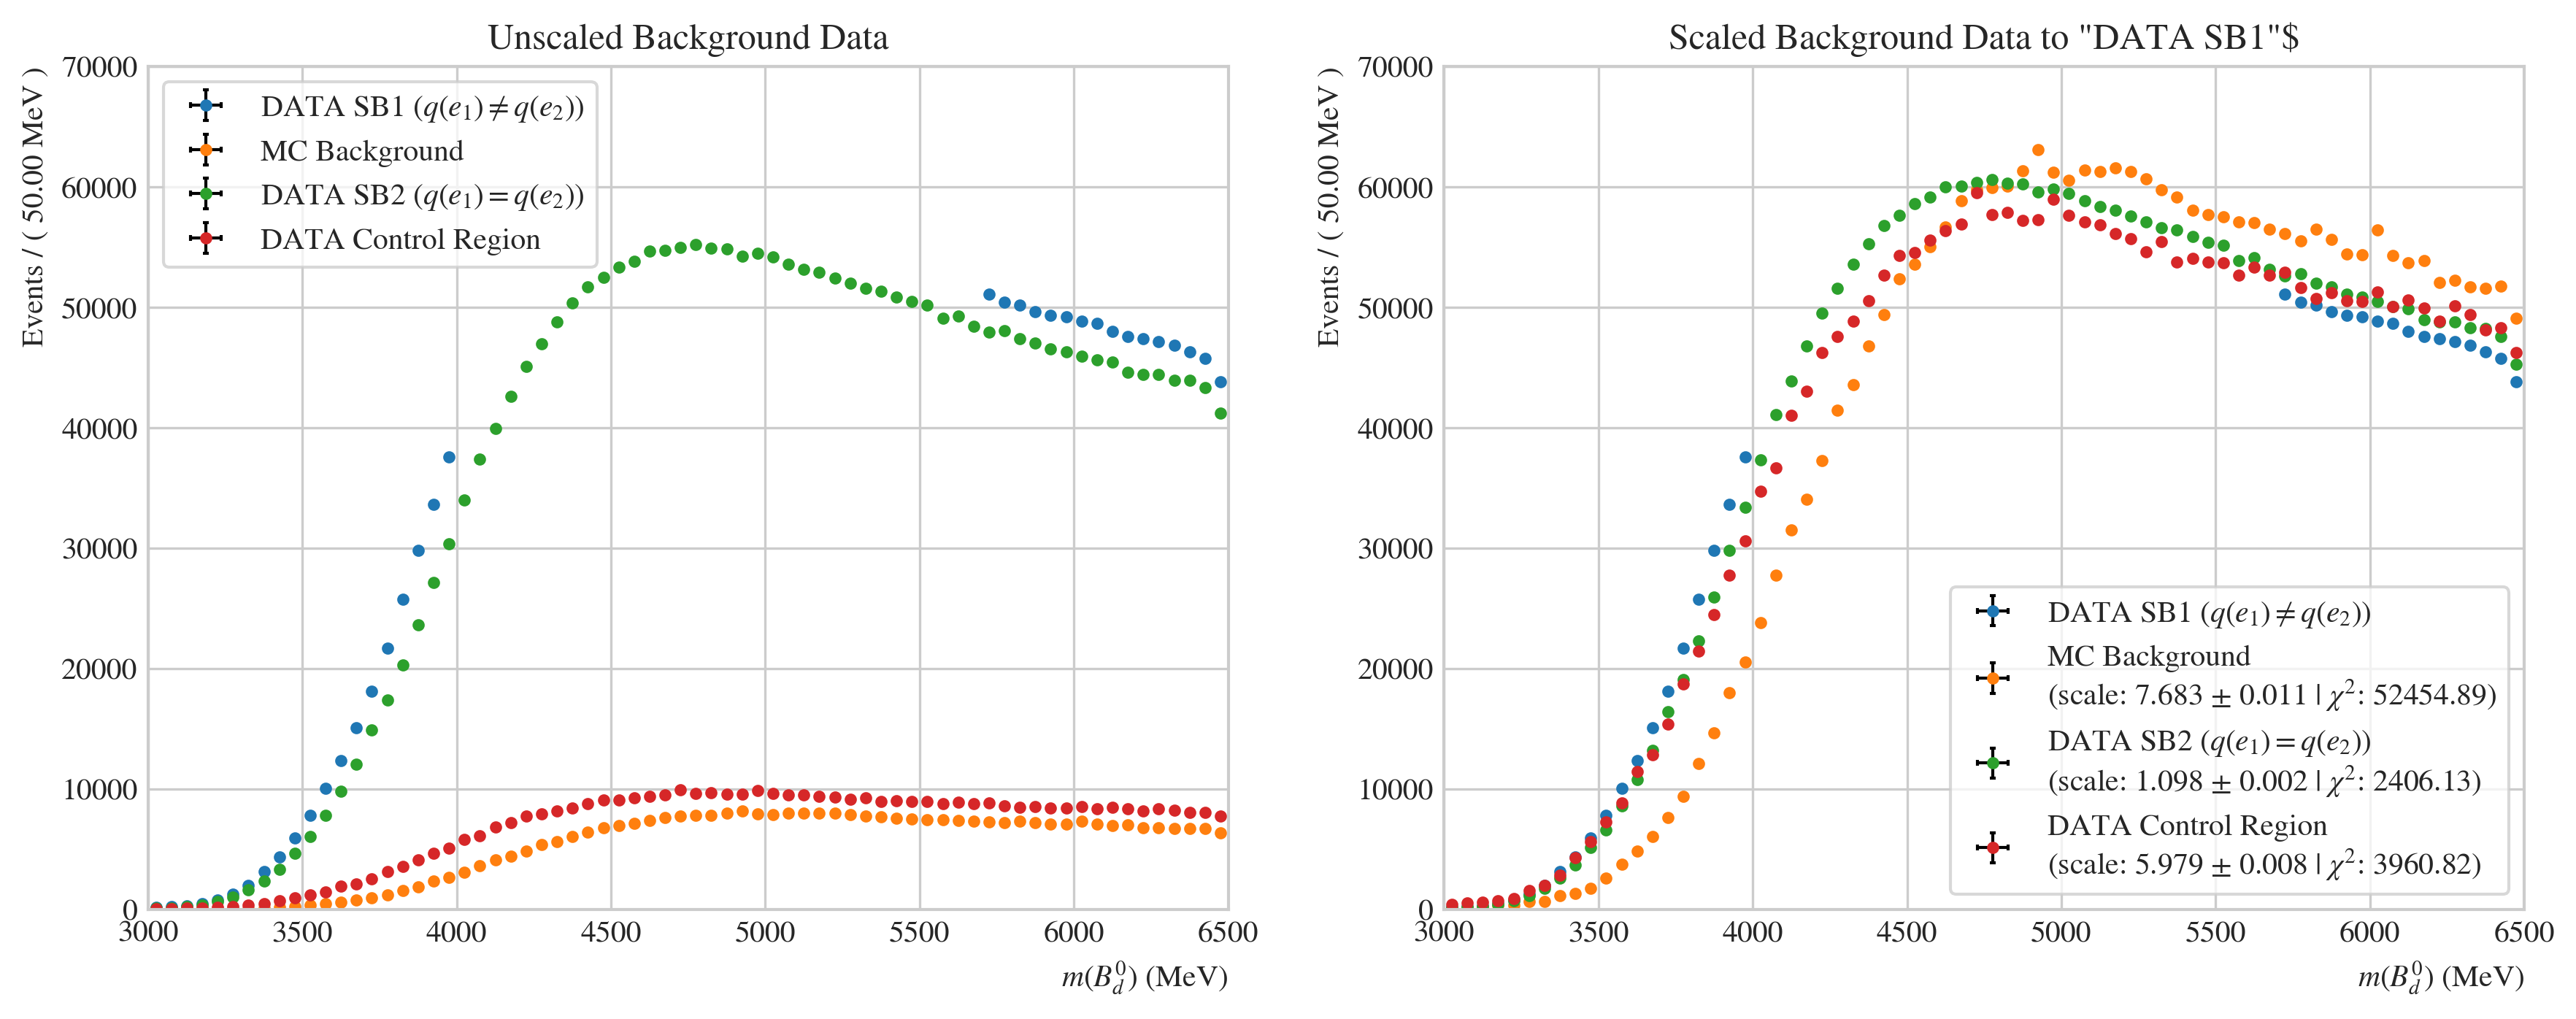

In [18]:
fig = plt.figure(figsize=(14,5),dpi=300)
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax1.errorbar(DATA_OS_hist['x_masked'], DATA_OS_hist['y_masked'], yerr=DATA_OS_hist['y_err_masked'], xerr=0.0, label='DATA SB1'+r' ($q(e_1)\neq q(e_2)$)', fmt='.',  ecolor='k', elinewidth=1, capsize=1, capthick=1)
ax1.errorbar(BKG_MC_hist['x_masked'], BKG_MC_hist['y_masked'], yerr=BKG_MC_hist['y_err_masked'], xerr=0.0, label='MC Background', fmt='.',  ecolor='k', elinewidth=1, capsize=1, capthick=1)
ax1.errorbar(DATA_SS_hist['x_masked'], DATA_SS_hist['y_masked'], yerr=DATA_SS_hist['y_err_masked'], xerr=0.0, label='DATA SB2'+r' ($q(e_1)=q(e_2))$', fmt='.',  ecolor='k', elinewidth=1, capsize=1, capthick=1)
ax1.errorbar(DATA_CR_hist['x_masked'], DATA_CR_hist['y_masked'], yerr=DATA_CR_hist['y_err_masked'], xerr=0.0, label='DATA Control Region', fmt='.',  ecolor='k', elinewidth=1, capsize=1, capthick=1)

ax2.errorbar(DATA_OS_hist['x_masked'], DATA_OS_hist['y_masked'], yerr=DATA_OS_hist['y_err_masked'], xerr=0.0, label='DATA SB1'+r' ($q(e_1)\neq q(e_2)$)', fmt='.',  ecolor='k', elinewidth=1, capsize=1, capthick=1)

string = f"\n(scale: {bkg_scale_result['BKG_MC_hist']['scale']:.3f} $\pm$ {bkg_scale_result['BKG_MC_hist']['error']:.3f} | $\chi^2$: {bkg_scale_result['BKG_MC_hist']['chi2']:.2f})"
ax2.errorbar(BKG_MC_hist['x_masked'], bkg_scale_result['BKG_MC_hist']['scale']*BKG_MC_hist['y_masked'], yerr=BKG_MC_hist['y_err_masked'], xerr=0.0, label='MC Background'+ string, fmt='.',  ecolor='k', elinewidth=1, capsize=1, capthick=1)

string = f"\n(scale: {bkg_scale_result['DATA_SS_hist']['scale']:.3f} $\pm$ {bkg_scale_result['DATA_SS_hist']['error']:.3f} | $\chi^2$: {bkg_scale_result['DATA_SS_hist']['chi2']:.2f})"
ax2.errorbar(DATA_SS_hist['x_masked'], bkg_scale_result['DATA_SS_hist']['scale']*DATA_SS_hist['y_masked'], yerr=DATA_SS_hist['y_err_masked'], xerr=0.0, label='DATA SB2'+r' ($q(e_1)=q(e_2))$'+string, fmt='.',  ecolor='k', elinewidth=1, capsize=1, capthick=1)

string = f"\n(scale: {bkg_scale_result['DATA_CR_hist']['scale']:.3f} $\pm$ {bkg_scale_result['DATA_CR_hist']['error']:.3f} | $\chi^2$: {bkg_scale_result['DATA_CR_hist']['chi2']:.2f})"
ax2.errorbar(DATA_CR_hist['x_masked'], bkg_scale_result['DATA_CR_hist']['scale']*DATA_CR_hist['y_masked'], yerr=DATA_CR_hist['y_err_masked'], xerr=0.0, label='DATA Control Region'+string, fmt='.',  ecolor='k', elinewidth=1, capsize=1, capthick=1)

ax1.set_title('Unscaled Background Data')
ax1.set_xlim(fit_config['full_xrange'][0],fit_config['full_xrange'][1])
ax2.set_xlim(fit_config['full_xrange'][0],fit_config['full_xrange'][1])
ax1.set_ylim(0,70000)
ax2.set_ylim(0,70000)
ax2.set_title('Scaled Background Data to "DATA SB1"$')
ax1.set_xlabel(f"$m(B_d^0)$ (MeV)",loc='right')
ax1.set_ylabel(f"Events / ( {fit_config['binwidth']:.2f} MeV )",loc='top')
ax2.set_xlabel(f"$m(B_d^0)$ (MeV)",loc='right')
ax2.set_ylabel(f"Events / ( {fit_config['binwidth']:.2f} MeV )",loc='top')
ax1.legend(framealpha=0.75,frameon=True,fancybox=True)
ax2.legend(framealpha=0.75,frameon=True,fancybox=True)
plt.show()

In [37]:
class Atan_Pol1:
    def __init__(self, N, f1, x_atan, s_atan,w_atan, loc_Pol1, scale_Pol1,a_Pol1, b_Pol1):
        self.f1 = f1
        self.range = None
        self.x_atan =x_atan
        self.s_atan = s_atan
        self.w_atan = w_atan
        self.a_Pol1 = a_Pol1
        self.b_Pol1 = b_Pol1
        self.loc_Pol1 =loc_Pol1
        self.scale_Pol1 = scale_Pol1
        self.N = N
        self.bin_width = None
    
    def set_static(self,bin_width,range):
        self.bin_width = bin_width
        self.range = range
        return self

    def _atan(self,x):
        x_scaled = (x-self.x_atan)/self.w_atan
        return np.arctan(x_scaled)+self.s_atan
    
    def _Pol1(self,x):
        x_scaled = (x-self.loc_Pol1)/self.scale_Pol1
        return self.a_Pol1 * x_scaled + self.b_Pol1

    def _integrate(self,func):
        return integrate.quad(func, self.range[0], self.range[1])[0]
    
    def _atan_norm(self,x):
        norm = self._integrate(self._atan)
        return self._atan(x) / norm
    
    def _Pol1_norm(self,x):
        norm = self._integrate(self._Pol1)
        return self._Pol1(x) / norm
    
    def _comb_PDF(self,x):
        return self.f1*self._atan_norm(x) + (1-self.f1)*self._Pol1_norm(x)
    
    def _comb_PDF_Norm(self,x):
        norm = self._integrate(self._comb_PDF)
        return self._comb_PDF(x) / norm

    def pdf(self, x):
        return self.N * self.bin_width * self._comb_PDF_Norm(x)
    
class Pol4:
    def __init__(self, N, a, b, c, d ,e, loc, w):
        self.a =a
        self.b= b
        self.c = c
        self.d = d
        self.e = e
        self.loc =loc
        self.w = w
        self.N = N
        self.range = None
        self.bin_width = None
    
    def set_static(self,bin_width,range):
        self.bin_width = bin_width
        self.range = range
        return self

    def _Pol4(self,x):
        x_scaled = (x-self.loc)/self.w
        return self.a * (x_scaled**4) + self.b * (x_scaled**3) + self.c * (x_scaled**2) + self.d * (x_scaled) + self.e

    def _integrate(self,func):
        return integrate.quad(func, self.range[0], self.range[1])[0]


    def pdf(self, x):
        return self.N * self.bin_width * self._Pol4(x)
    

class Atan_Exp:
    def __init__(self, N, f1, x_atan, s_atan, w_atan, loc_exp, w_exp, a_exp, b_exp):
        self.f1 = f1
        self.range = None
        self.x_atan =x_atan
        self.s_atan = s_atan
        self.w_atan = w_atan
        self.a_exp = a_exp
        self.b_exp = b_exp
        self.loc_exp =loc_exp
        self.w_exp = w_exp
        
        self.N = N
        self.bin_width = None
    
    def set_static(self,bin_width,range):
        self.bin_width = bin_width
        self.range = range
        return self

    def _atan(self,x):
        x_scaled = (x-self.x_atan)/self.w_atan
        return np.arctan(x_scaled)+self.s_atan
    
    def _exp(self,x):
        x_scaled = (x-self.loc_exp)/self.w_exp
        return np.exp(self.a_exp * x_scaled) + self.b_exp

    def _integrate(self,func):
        return integrate.quad(func, self.range[0], self.range[1])[0]
    
    def _atan_norm(self,x):
        norm = self._integrate(self._atan)
        return self._atan(x) / norm
    
    def _exp_norm(self,x):
        norm = self._integrate(self._exp)
        return self._exp(x) / norm
    
    def _comb_PDF(self,x):
        return self.f1*self._atan_norm(x) + (1-self.f1)*self._exp_norm(x)
    
    def _comb_PDF_Norm(self,x):
        norm = self._integrate(self._comb_PDF)
        return self._comb_PDF(x) / norm

    def pdf(self, x):
        return self.N * self.bin_width * self._comb_PDF_Norm(x)
    

In [41]:
def Atan_Pol_fit(x, N, f1, x_atan, s_atan,w_atan, loc_Pol1, scale_Pol1,a_Pol1, b_Pol1):
    return Atan_Pol1(N, f1, x_atan, s_atan,w_atan, loc_Pol1, scale_Pol1,a_Pol1, b_Pol1).set_static(bin_width=fit_config['binwidth'],range=fit_config['full_xrange']).pdf(x)

def Pol4_fit(x, N, a, b, c, d ,e, loc, w):
    return Pol4(N, a, b, c, d ,e, loc, w).set_static(bin_width=fit_config['binwidth'],range=fit_config['full_xrange']).pdf(x)

def Pol3_range_fit(x, N, a, b, c, d ,e, loc, w):
    return Pol4(N, a, b, c, d ,e, loc, w).set_static(bin_width=fit_config['binwidth'],range=fit_config['signal_xrange']).pdf(x)

def Atan_Exp_fit(x, N, f1, x_atan, s_atan, w_atan, loc_exp, w_exp, a_exp, b_exp):
    return Atan_Exp( N, f1, x_atan, s_atan, w_atan, loc_exp, w_exp, a_exp, b_exp).set_static(bin_width=fit_config['binwidth'],range=fit_config['full_xrange']).pdf(x)

Fit_params_Atan_Exp_fit = {
    'N':            [2623143,2610000,2640000,False],
    'f1':           [0.394,0.1,0.9,False],
    'x_atan':       [3920,3700,4200,False],
    's_atan':       [0.02,-2,3,False],
    'w_atan':       [352.8,0,None,False],
    'loc_exp':      [-33914.0,-34114,-33014,False],
    'w_exp':        [20363,19363,21363,False],
    'a_exp':        [2.0,1, 3,False],
    'b_exp':        [-62.0,-100,-5,False],    
} 

Fit_params_Atan_Pol_fit = {
    'N':            [2623596,2523596,2723596,False],
    'f1':           [1,0,1,False],
    'x_atan':       [3920,3700,4200,False],
    's_atan':       [0.02,-1,5,False],
    'w_atan':       [389.8,300,450,False],
    'loc_Pol1':     [5464,5000,6000,False],
    'scale_Pol1':   [-1.59,-3,0,False],
    'a_Pol1':       [-5.40,-7,-3,False],
    'b_Pol1':       [-1591,-1600,-1491,False],    
}
Fit_params_Pol4_fit = {
    'N':            [2623596,2523596,2723596,False],
    'a':            [1,None,None,False],
    'b':            [1,None,None,False],
    'c':            [0.02,None,None,False],
    'd':            [1,None,None,False],
    'e':            [1,None,None,False],
    'loc':          [4500,None,None,False],
    'w':            [.40,None,None,False],
}

Fit_params_Pol3_range_fit = {
    'N':            [2623596,2523596,2723596,False],
    'a':            [0,None,None,True],
    'b':            [1,None,None,False],
    'c':            [0.02,None,None,False],
    'd':            [1,None,None,False],
    'e':            [1,None,None,False],
    'loc':          [4500,None,None,False],
    'w':            [.40,None,None,False],
}

Fitter_dict = {'Atan_Pol1': [Atan_Pol_fit, Fit_params_Atan_Pol_fit, fit_config['full_xrange']],
               'Pol4': [Pol4_fit, Fit_params_Pol4_fit, fit_config['full_xrange']],
               'Atan_Exp': [Atan_Exp_fit, Fit_params_Atan_Exp_fit, fit_config['full_xrange']],
               'Pol3_range': [Pol3_range_fit, Fit_params_Pol3_range_fit, fit_config['signal_xrange']],
               'Pol4_range': [Pol4_fit, Fit_params_Pol4_fit, fit_config['signal_xrange']]}

In [42]:
Fitter_dict_res = {}

for i in Fitter_dict:
    np.random.seed(42)
    print(f'Fitting: {i}')
    minuit_object = Utils.Chi2Regression(Fitter_dict[i][0], DATA_SS_hist['x_masked'], DATA_SS_hist['y_masked'], DATA_SS_hist['y_err_masked'], bound=Fitter_dict[i][2]) 

    iminut_initializer = Utils.iminut_value_initializer(Fitter_dict[i][1], Fitter_dict[i][0])

    minuit_bkg = Minuit(minuit_object, *iminut_initializer.init_values(), name = iminut_initializer.names())
    minuit_bkg.errordef = Minuit.LEAST_SQUARES     
    iminut_initializer.limits_and_fixed(minuit_bkg)
    minuit_bkg.migrad()
    minuit_bkg.migrad()

    Fitter_dict_res[i] = minuit_bkg

Fitting: Atan_Pol1
Fitting: Pol4
Fitting: Atan_Exp
Fitting: Pol3_range
Fitting: Pol4_range


In [58]:
fig = plt.figure(figsize=(11,4),dpi=300)
ax1 = fig.add_subplot(111)
ax1.errorbar(DATA_SS_hist['x_masked'], DATA_SS_hist['y_masked'], yerr=DATA_SS_hist['y_err_masked'], xerr=0.0, label='DATA SB1'+r' ($q(e_1)\neq q(e_2)$)', fmt='.',  ecolor='k', elinewidth=1.5, capsize=1.5, capthick=1.5,markersize=10)
x_full = np.linspace(fit_config['full_xrange'][0], fit_config['full_xrange'][1], 1000)
x_sig = np.linspace(fit_config['signal_xrange'][0], fit_config['signal_xrange'][1], 1000)

ax1.plot(x_full, Fitter_dict['Atan_Pol1'][0](x_full, *Fitter_dict_res['Atan_Pol1'].values[:]), '-', label=f"Atan(x)+Pol1(x) | $\chi^2$: {Fitter_dict_res['Atan_Pol1'].fval:.3f}",lw=3,alpha=0.9) 
ax1.plot(x_full, Fitter_dict['Pol4'][0](x_full, *Fitter_dict_res['Pol4'].values[:]), '-', label=f"Pol4(x) |$\chi^2$: {Fitter_dict_res['Pol4'].fval:.3f}",lw=3,alpha=0.9) 
ax1.plot(x_full, Fitter_dict['Atan_Exp'][0](x_full, *Fitter_dict_res['Atan_Exp'].values[:]), '-', label=f"Atan(x)+Exp(x) |$\chi^2$: {Fitter_dict_res['Atan_Exp'].fval:.3f}",lw=3,alpha=0.9)
ax1.plot(x_sig, Fitter_dict['Pol3_range'][0](x_sig, *Fitter_dict_res['Pol3_range'].values[:]), '-', label=f"Pol3(x) (Signal Range) | $\chi^2$: {Fitter_dict_res['Pol3_range'].fval:.3f}",lw=3,alpha=0.9)
ax1.plot(x_sig, Fitter_dict['Pol4_range'][0](x_sig, *Fitter_dict_res['Pol4_range'].values[:]), '-', label=f"Pol4(x) (Signal Range) | $\chi^2$: {Fitter_dict_res['Pol4_range'].fval:.3f}",lw=3,alpha=0.9)

#plt.vlines(x=fit_config['signal_xrange'][0], ymin=0, ymax=70000, colors='green', ls=':', lw=2, label=f"Start of Signal Range ({fit_config['signal_xrange'][0]:.0f})")
#plt.vlines(x=fit_config['signal_xrange'][1], ymin=0, ymax=70000, colors='green', ls=':', lw=2, label=f"End of Signal Range ({fit_config['signal_xrange'][1]:.0f})")

ax1.set_ylabel(f"Events / ( {fit_config['binwidth']:.2f} MeV )",loc='top')
ax1.set_xlabel(f"$m(B_d^0)$ (MeV)",loc='right')
ax1.set_ylim(0,70000)
ax1.set_xlim(fit_config['full_xrange'][0],fit_config['full_xrange'][1])
ax1.legend(framealpha=0.75,frameon=True,fancybox=True)

#ax1.plot(x_axis, Atan_Exp_fit(x_axis, 1 , 0,1,1,1,2000,2000,-0.5,1), '-r', label=f'$\chi^2$: {chi2_value:.3f}') 
plt.show()

In [63]:
# Get number of degrees-of-freedom (Ndof):
N_NotEmptyBin = np.sum(DATA_SS_hist['y_masked'] > 0)
Ndof_value = N_NotEmptyBin - Fitter_dict_res['Pol4_range'].nfit
Prob_value = stats.chi2.sf(Fitter_dict_res['Pol4_range'].fval, Ndof_value) 

Prob_value
Ndof_value

62

In [ ]:
class DoubleGauss_Bukin:
    def __init__(self, N,f1,f2, Peak,sigmap,xi,rho1,rho2,sigma1,sigma2):
        self.f1 = f1
        self.f2 = f2
        
        # Bukin
        self.Peak =Peak
        self.sigmap = sigmap
        self.xi = xi
        self.rho1 = rho1
        self.rho2 = rho2

        # Gauss1
        self.sigma1 = sigma1
        
        # Gauss2
        self.sigma2 = sigma2
                
        self.N = N
        self.range = None
        self.bin_width = None
    
    def set_static(self,bin_width,range):
        self.bin_width = bin_width
        self.range = range
        return self

    def _Bukin(self,x):

        Xp = self.Peak
        hp = self.sigmap * 2 * np.sqrt(2 * np.log(2.0))
        r3 = np.log(2.0)
        r4 = np.sqrt(self.xi * self.xi + 1)

        if self.xi == 0:
            r1 = 0
            r5 = 1
        else:
            r1 = self.xi / r4
            r5 = np.select([np.abs(self.xi) > np.exp(-6.), np.abs(self.xi) <= np.exp(-6.)], [self.xi / np.log1p(r4 + self.xi), 1])

        x1 = Xp + (hp / 2) * (r1 - 1)
        x2 = Xp + (hp / 2) * (r1 + 1)

        condition_left = (x < x1)
        condition_center1 = ((x < x2) & (self.xi != 0))
        condition_center2 = ((x < x2) & (self.xi == 0))
        condition_right = ~(condition_left | condition_center1 | condition_center2)

        # Left Side
        left = self.rho1 * (x - x1) ** 2 / (Xp - x1) ** 2 - r3 + 4 * r3 * (x - x1) / hp * r5 * r4 / (r4 - self.xi) ** 2

        # Center
        center1 = -r3 * np.log1p(4 * self.xi * r4 * (x - Xp) / hp) ** 2 / np.log1p(2 * self.xi * (self.xi - r4)) ** 2

        center2 = -4 * r3 * (x - Xp) ** 2 / hp ** 2

        # Right Side
        right = self.rho2 * (x - x2) ** 2 / (Xp - x2) ** 2 - r3 - 4 * r3 * (x - x2) / hp * r5 * r4 / (r4 + self.xi) ** 2

        result = np.select([condition_left, condition_center1, condition_center2, condition_right], [left, center1, center2, right])

        return result
    
    def _Gauss1(self,x):
        return 1.0 / np.sqrt(2*np.pi) / self.sigma1 * np.exp( -0.5 * (x-self.Peak)**2 / self.sigma1**2)
    
    def _Gauss2(self,x):
        return 1.0 / np.sqrt(2*np.pi) / self.sigma2 * np.exp( -0.5 * (x-self.Peak)**2 / self.sigma2**2)
    
    def _integrate(self,func):
        return integrate.quad(func, self.range[0], self.range[1])[0]


    def doubleGauss_Bukin_norm(self,x):

        in_interval:bool = ((x >= self.range[0]) & (x <= self.range[1]))

        # Define the funcions
        Gauss1 = self._Gauss1(x)
        Gauss2 = self._Gauss2(x)
        Bukin = self._Bukin(x)

        # Combine
        D_Gauss_Bukin = (self.f2*((self.f1 * Gauss1) + ((1-self.f1) * Gauss2))) + ((1-self.f2)*Bukin)
        norm_D_Gauss_Bukin = integrate.quad(lambda x: (  (self.f2*((self.f1 * self._Gauss1(x)) + ((1-self.f1) * self._Gauss2(x)))) + ((1-self.f2)*self._Bukin(x))   ), self.range[0], self.range[1])[0]
        D_Gauss_Bukin =  np.where(in_interval, D_Gauss_Bukin / norm_D_Gauss_Bukin, 0.)
        return D_Gauss_Bukin
    
    def pdf(self, x):
        return self.N * self.bin_width * self.doubleGauss_Bukin_norm(x)
    
    
def DoubleGauss_Bukin_fit(x, N,f1,f2, Peak,sigmap,xi,rho1,rho2,sigma1,sigma2):
    return DoubleGauss_Bukin(N,f1,f2, Peak,sigmap,xi,rho1,rho2,sigma1,sigma2).set_static(bin_width=fit_config['binwidth'],range=fit_config['signal_xrange']).pdf(x)


In [ ]:
class DoubleCrystal:
    def __init__(self, N,f1, peak,beta1, m1, scale1, beta2, m2, scale2):
        self.f1 = f1

        self.peak = peak

        # CB1
        self.beta1 = beta1
        self.m1 = m1
        self.scale1 = scale1
        
        # CB2
        self.beta2 = beta2
        self.m2 = m2
        self.scale2 = scale2
                
        self.N = N
        self.range = None
        self.bin_width = None
    
    def set_static(self,bin_width,range):
        self.bin_width = bin_width
        self.range = range
        return self
    
    def _CB1(self,x):
        return stats.crystalball.pdf(x, self.beta1, self.m1, self.peak, self.scale1) 
    
    def _CB2(self,x):
        return stats.crystalball.pdf(x, self.beta2, self.m2, self.peak, self.scale2) 

    def _integrate(self,func):
        return integrate.quad(func, self.range[0], self.range[1])[0]

    def doubleCB(self,x):
        in_interval:bool = ((x >= self.range[0]) & (x <= self.range[1]))

        # Define the funcions
        CB1 = self._CB1(x)
        CB2 = self._CB2(x)

        # Combine
        doubleCB = (self.f1 * CB1) + ((1-self.f1) * CB2)
        norm_doubleCB = integrate.quad(lambda x: (  (self.f1 * self._CB1(x)) + ((1-self.f1) * self._CB2(x))  ), self.range[0], self.range[1])[0]
        doubleCB =  np.where(in_interval, doubleCB / norm_doubleCB, 0.)
        return doubleCB
    
    def pdf(self, x):
        return self.N * self.bin_width * self.doubleCB(x)


def DoubleCrystal_fit(x,N, f1, peak,beta1, m1, scale1, beta2, m2, scale2):
   return DoubleCrystal(N, f1, peak,beta1, m1, scale1, beta2, m2, scale2).set_static(bin_width=fit_config['binwidth'],range=fit_config['signal_xrange']).pdf(x)



In [209]:
def DoubleGauss_Bukin_fit(x, N,f1,f2, Peak,sigmap,xi,rho1,rho2,sigma1,sigma2):
    DGB = DoubleGauss_Bukin(N,f1,f2, Peak,sigmap,xi,rho1,rho2,sigma1,sigma2)
    DGB.set_static(bin_width=fit_config['binwidth'],range=fit_config['signal_xrange'])
    return DGB.pdf(x)

In [215]:
DoubleGauss_Bukin_fit(5000, *minuit_sig.values[:])

0.17672475801474943

In [20]:
select_Res_Bd = f"((info_sample == '300592') & (info_truth_matching == 1))"
MC_Signal_Res_Bd = MC_USR_highq2.query(select_Res_Bd).B_mass_true
MC_Signal_Res_Bd_hist=data_to_hist_converter(data=MC_Signal_Res_Bd, bins=fit_config['Bins'])



findfont: Font family 'Tex Gyre Heros' not found.
findfont: Font family 'Tex Gyre Heros' not found.
findfont: Font family 'Tex Gyre Heros' not found.
findfont: Font family 'Tex Gyre Heros' not found.
findfont: Font family 'Tex Gyre Heros' not found.
findfont: Font family 'Tex Gyre Heros' not found.
findfont: Font family 'Tex Gyre Heros' not found.
findfont: Font family 'Tex Gyre Heros' not found.
findfont: Font family 'Tex Gyre Heros' not found.
findfont: Font family 'Tex Gyre Heros' not found.
findfont: Font family 'Tex Gyre Heros' not found.
findfont: Font family 'Tex Gyre Heros' not found.
findfont: Font family 'Tex Gyre Heros' not found.
findfont: Font family 'Tex Gyre Heros' not found.
findfont: Font family 'Tex Gyre Heros' not found.
findfont: Font family 'Tex Gyre Heros' not found.
findfont: Font family 'Tex Gyre Heros' not found.
findfont: Font family 'Tex Gyre Heros' not found.
findfont: Font family 'Tex Gyre Heros' not found.
findfont: Font family 'Tex Gyre Heros' not found.


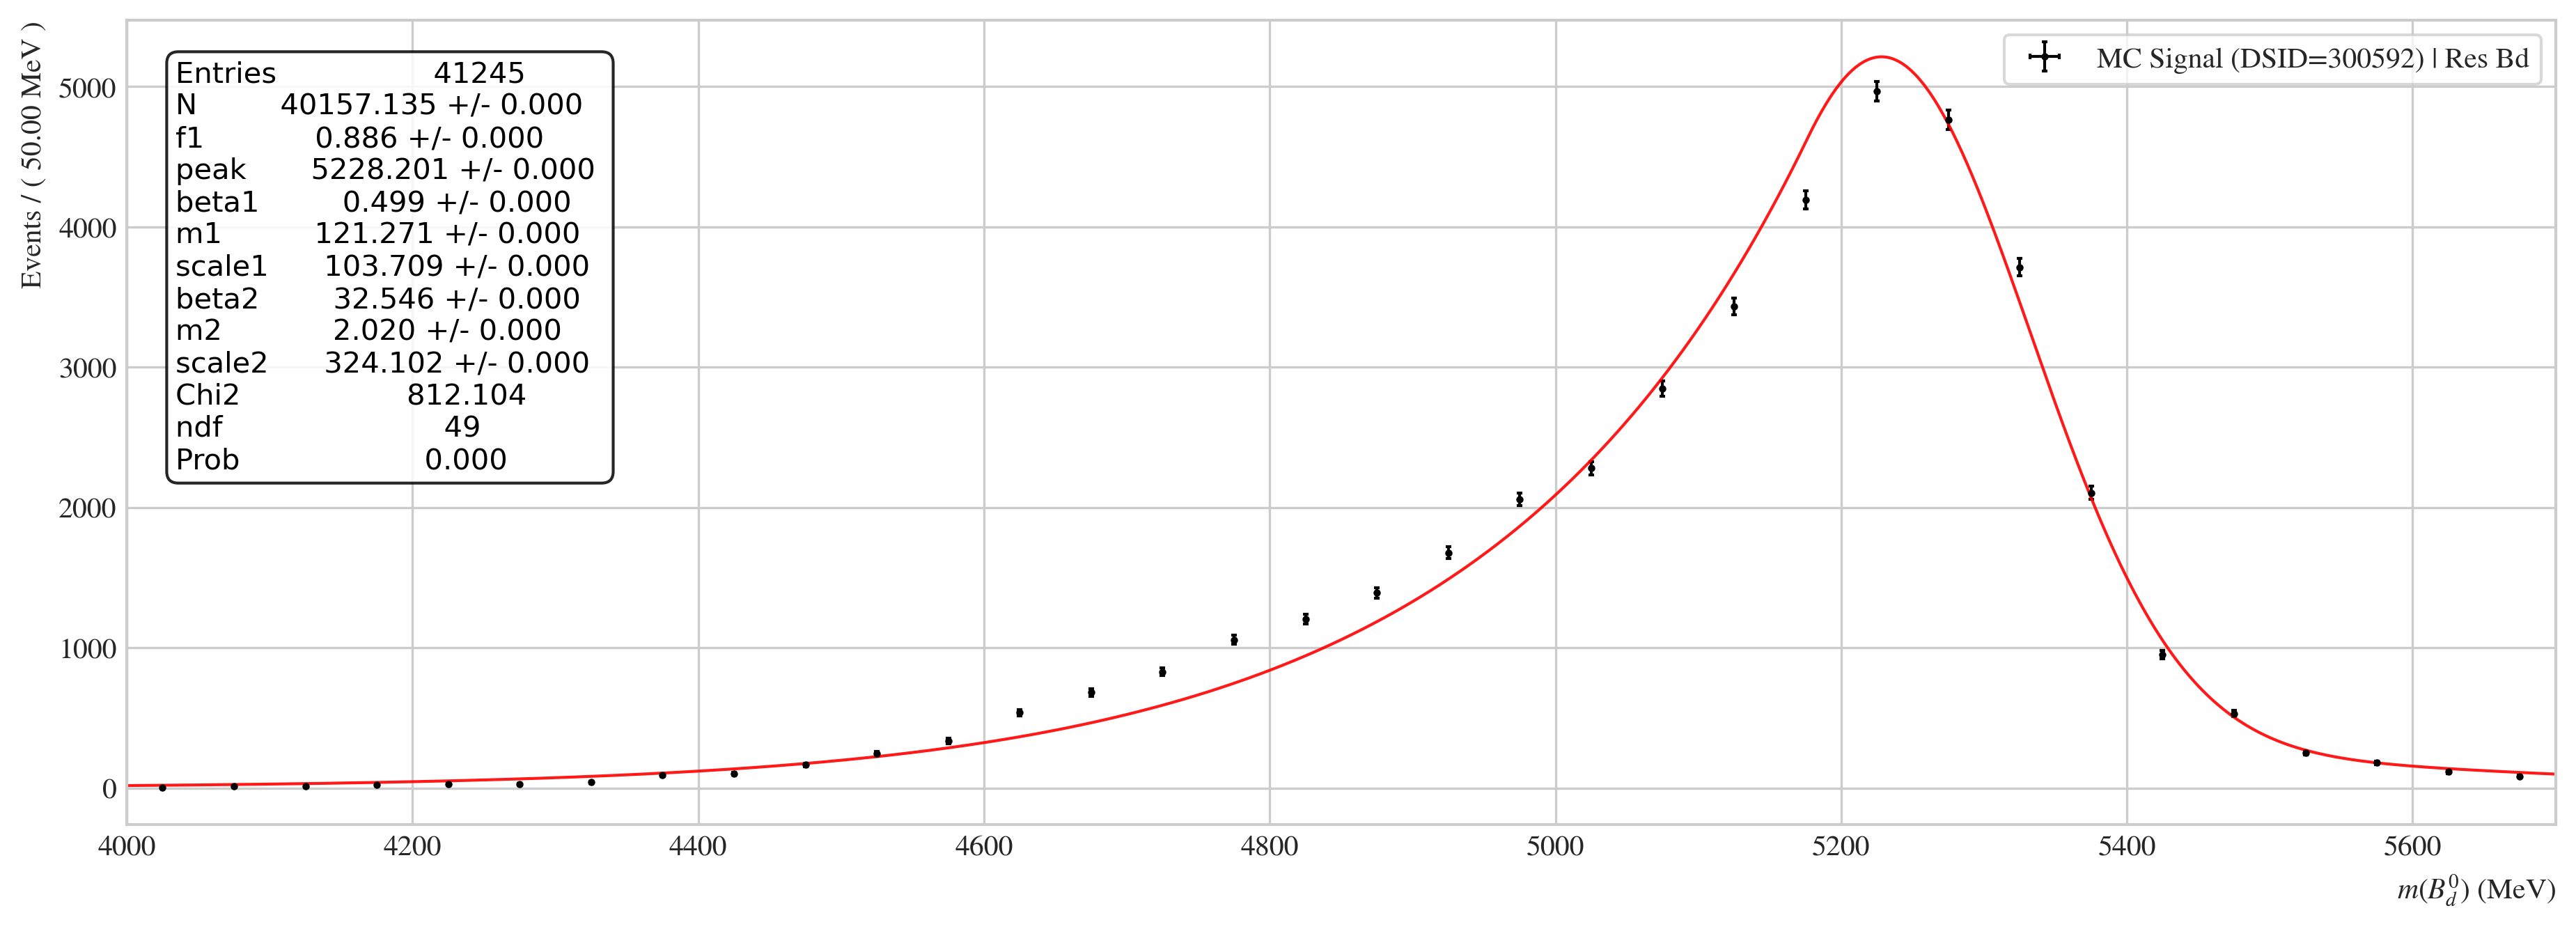

In [81]:
import scipy.stats
# Get Chi2 value:
chi2_value = minuit_sig.fval            # The value minimised, i.e. Chi2 or -2*LogLikeliHood (LLH) value

# Get number of degrees-of-freedom (Ndof):
N_NotEmptyBin = np.sum(MC_Signal_Res_Bd_hist['y_masked'] > 0)
Ndof_value = N_NotEmptyBin - minuit_sig.nfit
Prob_value = scipy.stats.chi2.sf(chi2_value, Ndof_value) # The chi2 probability given N_DOF degrees of freedom

# Adding fit results to plot:
d = {'Entries': MC_Signal_Res_Bd_hist['y_masked'].sum()}
for name in minuit_sig.parameters:
    value, error = minuit_sig.values[name], minuit_sig.errors[name]
    d[name] = [value,error]

d['Chi2']= chi2_value
d['ndf']= Ndof_value
d['Prob']= Prob_value


fig = plt.figure(figsize=(15,5),dpi=300)
ax1 = fig.add_subplot(111)
ax1.errorbar(MC_Signal_Res_Bd_hist['x_masked'], MC_Signal_Res_Bd_hist['y_masked'], yerr=MC_Signal_Res_Bd_hist['y_err_masked'], xerr=0.0, label='MC Signal (DSID=300592) | Res Bd', fmt='.k',  ecolor='k', elinewidth=1, capsize=1, capthick=1,markersize=3)

ax1.set_ylabel(f"Events / ( {fit_config['binwidth']:.2f} MeV )",loc='top')
ax1.set_xlabel(f"$m(B_d^0)$ (MeV)",loc='right')
#ax1.set_ylim(0,6000)
ax1.set_xlim(fit_config['signal_xrange'][0],fit_config['signal_xrange'][1])
ax1.legend(framealpha=0.75,frameon=True,fancybox=True)
x_sig = np.linspace(fit_config['signal_xrange'][0], fit_config['signal_xrange'][1], 1000)

text = Utils.nice_string_output(d, extra_spacing=3, decimals=3)
Utils.add_text_to_ax(0.02, 0.95, text, ax1, fontsize=10)
#ax1.plot(x_sig, DoubleGauss_Bukin_fit(x_sig, *minuit_sig.values[:]), '-r', label=f"Pol4(x) (Signal Range) | $\chi^2$: {'minuit_sig.fval:.3f'}",lw=1,alpha=0.9)

ax1.plot(x_sig, DoubleCrystal_fit(x_sig, *minuit_sig.values[:]), '-r', label=f"Pol4(x) (Signal Range) | $\chi^2$: {'minuit_sig.fval:.3f'}",lw=1,alpha=0.9)
plt.show()

In [35]:

np.random.seed(42)
Fit_params_DoubleGauss_Bukin_fit = {
    'N':            [41245,40000,43245,False],
    'f1':           [0.5,0.01,0.99,False],
    'f2':           [0.5,0.01,0.99,False],
    'Peak':         [5234,4000,5700,False],
    'sigmap':       [200,None,None,False],
    'xi':           [-1.1,None,None,False],
    'rho1':         [0.5,None,None,False],
    'rho2':         [0.39,None,None,False],
    'sigma1':       [300,None,None,False],
    'sigma2':       [100,None,None,False],
}

[40611.949368278656,
 0.7715443827370543,
 0.9999863467175497,
 5234.604161440538,
 200.67148910943675,
 -1.9336336964114886,
 0.512763309830867,
 0.39534392115269373,
 347.83646427498417,
 100.00000026047037]
minuit_object = Utils.Chi2Regression(DoubleGauss_Bukin_fit, MC_Signal_Res_Bd_hist['x_masked'], MC_Signal_Res_Bd_hist['y_masked'], MC_Signal_Res_Bd_hist['y_err_masked'], bound=fit_config['signal_xrange']) 
iminut_initializer = Utils.iminut_value_initializer(Fit_params_DoubleGauss_Bukin_fit, DoubleGauss_Bukin_fit)

minuit_sig = Minuit(minuit_object, *iminut_initializer.init_values(), name = iminut_initializer.names())
minuit_sig.errordef = Minuit.LEAST_SQUARES     
iminut_initializer.limits_and_fixed(minuit_sig)

print('1')
minuit_sig.migrad()    
print('2')                  
minuit_sig.migrad()   
print('3')        
minuit_sig.hesse()


1
2
3


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 1.562e+04                  │             Nfcn = 4955              │
│ EDM = 0.714 (Goal: 0.0002)       │           time = 36.6 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│         INVALID Minimum          │       SOME Parameters at limit       │
├──────────────────────────────────┼──────────────────────────────────────┤
│ ABOVE EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │APPROXIMATE│NOT pos. def.│   FORCED   │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name   │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ N      │ 40.0000e3 │ 0.0014e3  │            │            │  40000  │  43245  │       │
│ 1 │ f1     │    1.0    │    0.8    │            │            │  0.01   │  0.99   │       │
│ 2 │ f2     │    1.0    │    0.8    │            │            │  0.01   │  0.99   │       │
│ 3 │ Peak   │ 4.5203e3  │ 0.0012e3  │            │            │  4000   │  5700   │       │
│ 4 │ sigmap │   4.401   │   0.031   │            │            │         │         │       │
│ 5 │ xi     │   -5.62   │   0.04    │            │            │         │         │       │
│ 6 │ rho1   │    6.9    │    0.9    │            │            │         │         │       │
│ 7 │ rho2   │ -73.9e-3  │  0.5e-3   │            │            │         │         │       │
│ 8 │ sigma1 │  -993.4   │    2.0    │            │            │         │         │       │
│ 9 │ sigma2 │-15.6105e3 │ 0.0020e3  │            │            │         │         │       │
└───┴────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────────┬─────────────────────────────────────────────────────────────────────────────────────────────────────┐
│        │         N        f1        f2      Peak    sigmap        xi      rho1      rho2    sigma1    sigma2 │
├────────┼─────────────────────────────────────────────────────────────────────────────────────────────────────┤
│      N │     0.117 -2.06e-11 -5.38e-10  1.52e-05 -1.31e-07 -2.29e-07  1.99e-06 -1.94e-09 -3.67e-12  1.72e-13 │
│     f1 │ -2.06e-11   0.00632 -1.76e-06 -3.45e-08  -1.7e-09 -3.61e-09  1.52e-07 -1.44e-11 -1.42e-08  3.84e-11 │
│     f2 │ -5.38e-10 -1.76e-06    0.0578 -1.18e-06 -5.87e-08 -1.24e-07  5.25e-06 -4.92e-10 -4.53e-07 -1.45e-11 │
│   Peak │  1.52e-05 -3.45e-08 -1.18e-06      1.53  -0.00204   0.00317   -0.0574 -3.14e-05 -9.74e-09  4.94e-12 │
│ sigmap │ -1.31e-07  -1.7e-09 -5.87e-08  -0.00204  0.000957  0.000748  -0.00235  -6.3e-06  -4.6e-10 -3.33e-13 │
│     xi │ -2.29e-07 -3.61e-09 -1.24e-07   0.00317  0.000748   0.00189  -0.00829  1.14e-05 -9.64e-10 -4.44e-13 │
│   rho1 │  1.99e-06  1.52e-07  5.25e-06   -0.0574  -0.00235  -0.00829      0.76 -6.22e-05   2.6e-08  2.89e-12 │
│   rho2 │ -1.94e-09 -1.44e-11 -4.92e-10 -3.14e-05  -6.3e-06  1.14e-05 -6.22e-05  2.55e-07 -4.13e-12 -4.53e-16 │
│ sigma1 │ -3.67e-12 -1.42e-08 -4.53e-07 -9.74e-09  -4.6e-10 -9.64e-10   2.6e-08 -4.13e-12      3.98 -5.48e-16 │
│ sigma2 │  1.72e-13  3.84e-11 -1.45e-11  4.94e-12 -3.33e-13 -4.44e-13  2.89e-12 -4.53e-16 -5.48e-16      3.98 │
└────────┴─────────────────────────────────────────────────────────────────────────────────────────────────────┘

In [80]:
np.random.seed(42)
Fit_params_DoubleCrystal_fit = {
    'N':            [41245,39000,44000,False],
    'f1':           [0.5,0.0,1,False],
    'peak':         [5234,4000,5700,False],
    'beta1':        [2,None,None,False],
    'm1':           [2,1.00001,None,False],
    'scale1':       [235.80362,None,None,False],
    'beta2':        [2,0,None,False],
    'm2':           [2,1.0001,None,False],
    'scale2':       [235.80362,None,None,False],
}
[40611.949368278656,
 0.7715443827370543,
 0.9999863467175497,
 5234.604161440538,
 200.67148910943675,
 -1.9336336964114886,
 0.512763309830867,
 0.39534392115269373,
 347.83646427498417,
 100.00000026047037]
minuit_object = Utils.Chi2Regression(DoubleCrystal_fit, MC_Signal_Res_Bd_hist['x_masked'], MC_Signal_Res_Bd_hist['y_masked'], MC_Signal_Res_Bd_hist['y_err_masked'], bound=fit_config['signal_xrange']) 
iminut_initializer = Utils.iminut_value_initializer(Fit_params_DoubleCrystal_fit, DoubleCrystal_fit)

minuit_sig = Minuit(minuit_object, *iminut_initializer.init_values(), name = iminut_initializer.names())
minuit_sig.errordef = Minuit.LEAST_SQUARES     
iminut_initializer.limits_and_fixed(minuit_sig)

print('1')
minuit_sig.migrad()    
print('2')                  
minuit_sig.migrad()   
print('3')        
minuit_sig.hesse()

1
2
3


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 812.1                      │             Nfcn = 1444              │
│ EDM = 12.1 (Goal: 0.0002)        │           time = 106.4 sec           │
├──────────────────────────────────┼──────────────────────────────────────┤
│         INVALID Minimum          │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ ABOVE EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │   Hesse FAILED   │APPROXIMATE│NOT pos. def.│ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name   │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ N      │ 4.0157e4  │ 0.0000e4  │            │            │  39000  │  44000  │       │
│ 1 │ f1     │ 8.8559e-1 │ 0.0000e-1 │            │            │    0    │    1    │       │
│ 2 │ peak   │ 5.2282e3  │ 0.0000e3  │            │            │  4000   │  5700   │       │
│ 3 │ beta1  │ 4.9923e-1 │ 0.0000e-1 │            │            │         │         │       │
│ 4 │ m1     │ 1.2127e2  │ 0.0000e2  │            │            │ 1.00001 │         │       │
│ 5 │ scale1 │ 1.0371e2  │ 0.0000e2  │            │            │         │         │       │
│ 6 │ beta2  │ 3.2546e1  │ 0.0000e1  │            │            │    0    │         │       │
│ 7 │ m2     │  2.0199   │  0.0000   │            │            │ 1.0001  │         │       │
│ 8 │ scale2 │  3.241e2  │  0.000e2  │            │            │         │         │       │
└───┴────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘

In [78]:
minuit_sig.values[:]

[40000.002840349436,
 0.0,
 5211.678692202432,
 2.0,
 2.0,
 235.80362,
 0.6215618146351192,
 115.12637428497854,
 128.00601140802542]

In [70]:
np.mean(MC_Signal_Res_Bd)




5123.965

In [71]:
np.std(MC_Signal_Res_Bd)

235.80362

In [72]:
np.median(MC_Signal_Res_Bd)

5169.4116

In [73]:
stats.skew(MC_Signal_Res_Bd)

-0.5549370795302009

In [74]:
stats.kurtosis(MC_Signal_Res_Bd)

1.8904964030381262